In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

# Bring in the data

In [2]:
Data = pd.read_excel('WhakatuClimatedata-2001-2009.xls',
                     sheet_name='MetData',skiprows=range(11),
                     ).loc[:,('Rg','Tmax','Tmin','RH','Wind','RF','Date(NZST)')]
Data.columns = [u'Radn',u'MaxT',u'MinT',u'Humidity',u'Wind',u'Rain','Date']                    
Data.loc[:,'MeanT'] = np.mean([Data.MinT,Data.MaxT], axis=0)
Data.loc[:,'vp'] = [et.vp(Data.loc[x,'MeanT'],Data.loc[x,'Humidity']) for x in Data.index]
Data.loc[:,'Day'] = [Data.loc[x,'Date'].dayofyear for x in Data.index]
Data.loc[:,'Year'] = [Data.loc[x,'Date'].year for x in Data.index]
Data.set_index(['Year','Day'],drop=False,inplace=True)

## Calculate Potential Evapotranspiration

In [3]:
Data.loc[:,'PET'] = [et.PenmanEO(Data.loc[x,'Radn'],
                            Data.loc[x,'MeanT'],
                            Data.loc[x,'Wind'],
                            Data.loc[x,'vp'],
                            "total") for x in Data.index]

## Calculate long term means

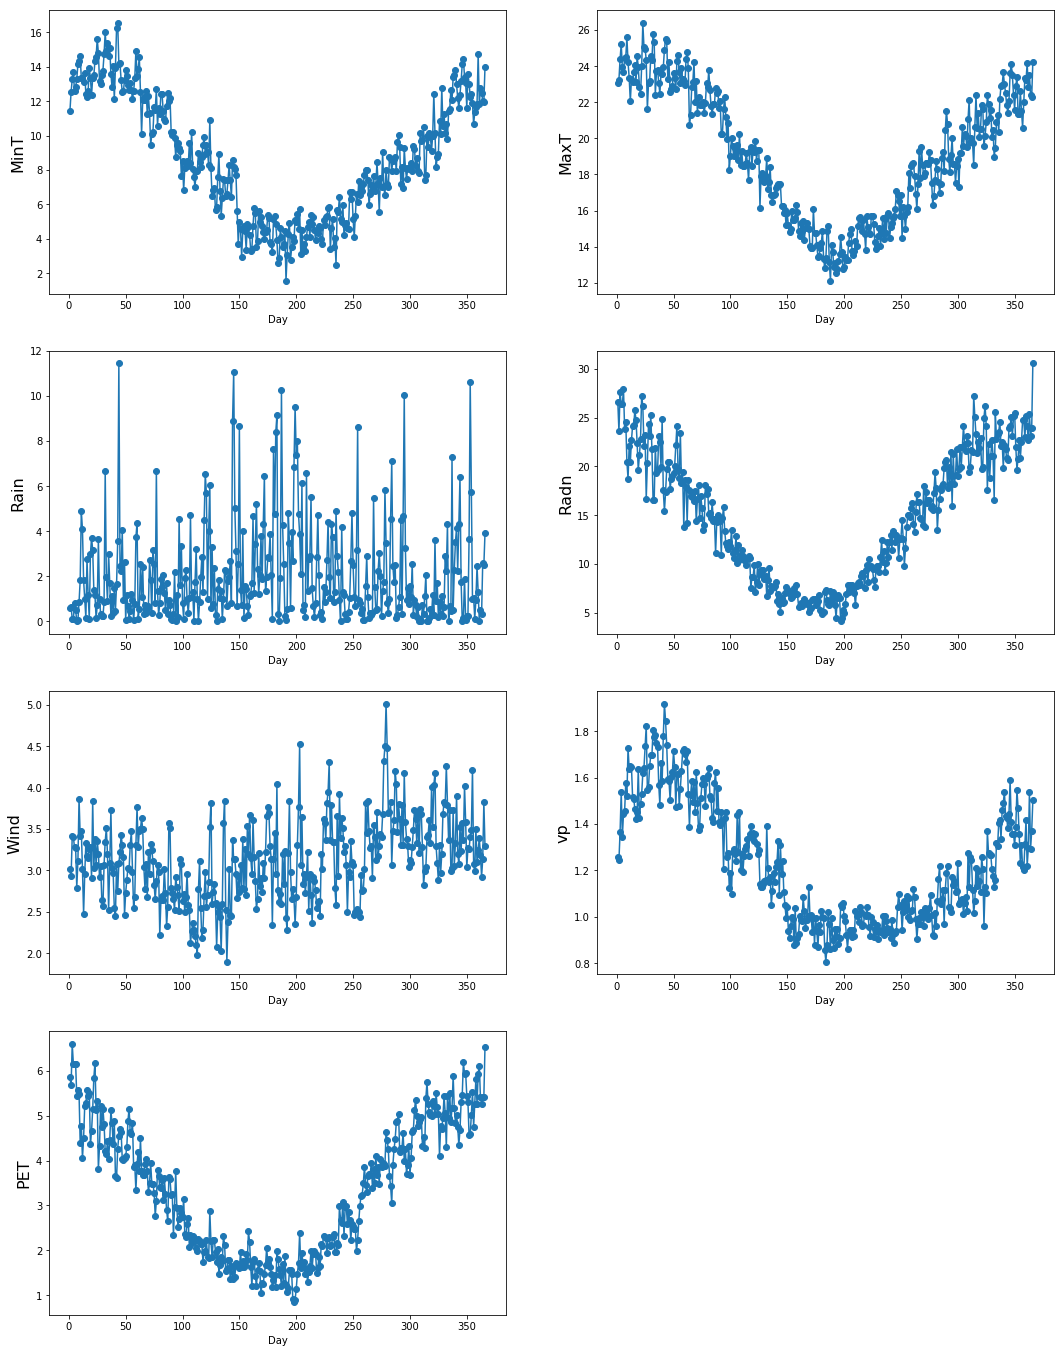

In [4]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp','PET']:
    Fig.add_subplot(4,2,Position)
    Means = Data.groupby(level='Day').mean()
    Means.loc[:,x].plot(marker='o')
    plt.ylabel(x,fontsize = 16)
    Position +=1

[Text(0,0,'1-Jan'),
 Text(0,0,'1-Mar'),
 Text(0,0,'1-Jun'),
 Text(0,0,'1-Sep'),
 Text(0,0,'1-Jan')]

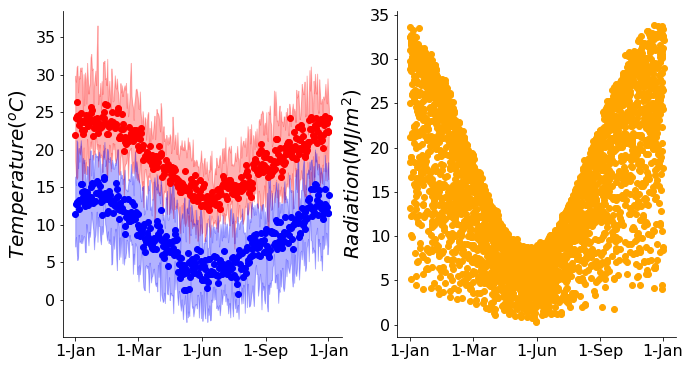

In [5]:
Fig = plt.figure(figsize = (11,6))
#for x in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp']:
Ax = Fig.add_subplot(1,2,1)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
Medians = Data.loc[:,'MaxT'].groupby(level='Day').median()
#SEs = Data.groupby(level='Day').std()
Upper = Data.loc[:,'MaxT'].groupby(level='Day').max()
Lower = Data.loc[:,'MaxT'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='r')
plt.plot(Medians,'o',color='r')
Medians = Data.loc[:,'MinT'].groupby(level='Day').median()
#SEs = Data.groupby(level='Day').std()
Upper = Data.loc[:,'MinT'].groupby(level='Day').max()
Lower = Data.loc[:,'MinT'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='b')
plt.plot(Medians,'o',color='b')
plt.ylabel(r'$Temperature (^oC)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])
Ax = Fig.add_subplot(1,2,2)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
DayIndexed = Data.copy()
DayIndexed.index = DayIndexed.index.droplevel('Year')
plt.plot(DayIndexed.index,DayIndexed.loc[:,'Radn'],'o',color='orange')
plt.ylabel(r'$Radiation (MJ/m^2)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])

# Replace suspect data with -99, or

In [6]:
CleanData = Data.copy()
CleanData.loc[:,'MinT'].where(CleanData.loc[:,'MinT']>-10,-99,inplace=True)
CleanData.loc[:,'MaxT'].where(CleanData.loc[:,'MaxT']<35,-99,inplace=True)
CleanData.loc[:,'Rain'].where(CleanData.loc[:,'Rain']<200,-99,inplace=True)
CleanData.loc[:,'Radn'].where(CleanData.loc[:,'Radn']<35,-99,inplace=True)
CleanData.loc[:,'Wind'].where(CleanData.loc[:,'Wind']<2000,-99,inplace=True)
CleanData.loc[:,'vp'].where(CleanData.loc[:,'vp']<30,-99,inplace=True)
CleanData.loc[:,'PET'].where(CleanData.loc[:,'PET']>0,-99,inplace=True)

# Replace suspect data with long term mean

In [7]:
for var in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp', u'PET']:
    for x in CleanData.index:
        Day = CleanData.loc[x,'Day']
        if CleanData.loc[x,var] == -99:
            CleanData.loc[x,var] = Means.loc[Day,var]

## Replace missing data with long term means

In [8]:
for var in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp']:
    for x in CleanData.index:
        if np.isnan(CleanData.loc[x,var]):
            Day = CleanData.loc[x,'Day']
            CleanData.loc[x,var] = Means.loc[Day,var]

## output met data so it can be used elsewhere

In [13]:
CleanData.to_pickle('WhakatuMet.pkl')

## Add APSIM header info into met file

In [9]:
CleanData.loc[:,[u'Rain',u'MaxT',u'MinT',u'Radn', u'Wind', u'vp'
                ]].round(2).to_csv('Whakatu.met',sep='\t',header=False)
ApsimFile = open('Whakatu.met','r+')
content = ApsimFile.read()
ApsimFile.seek(0,0)
ApsimFile.write('[weather.met.weather]\n' + 
                'Latitude=-39.61\n' +
                'Longitude=176912\n' +
                'tav = 13\n' +
                'amp = 11\n' +
                'year\tday\train\tmaxt\tmint\tradn\twind\tvp\n'
                '()\t()\t(mm)\t(oC)\t(oC)\t(MJ/m2/d)\t(m/s)\t(mbar)\n'+
                content)
ApsimFile.close()

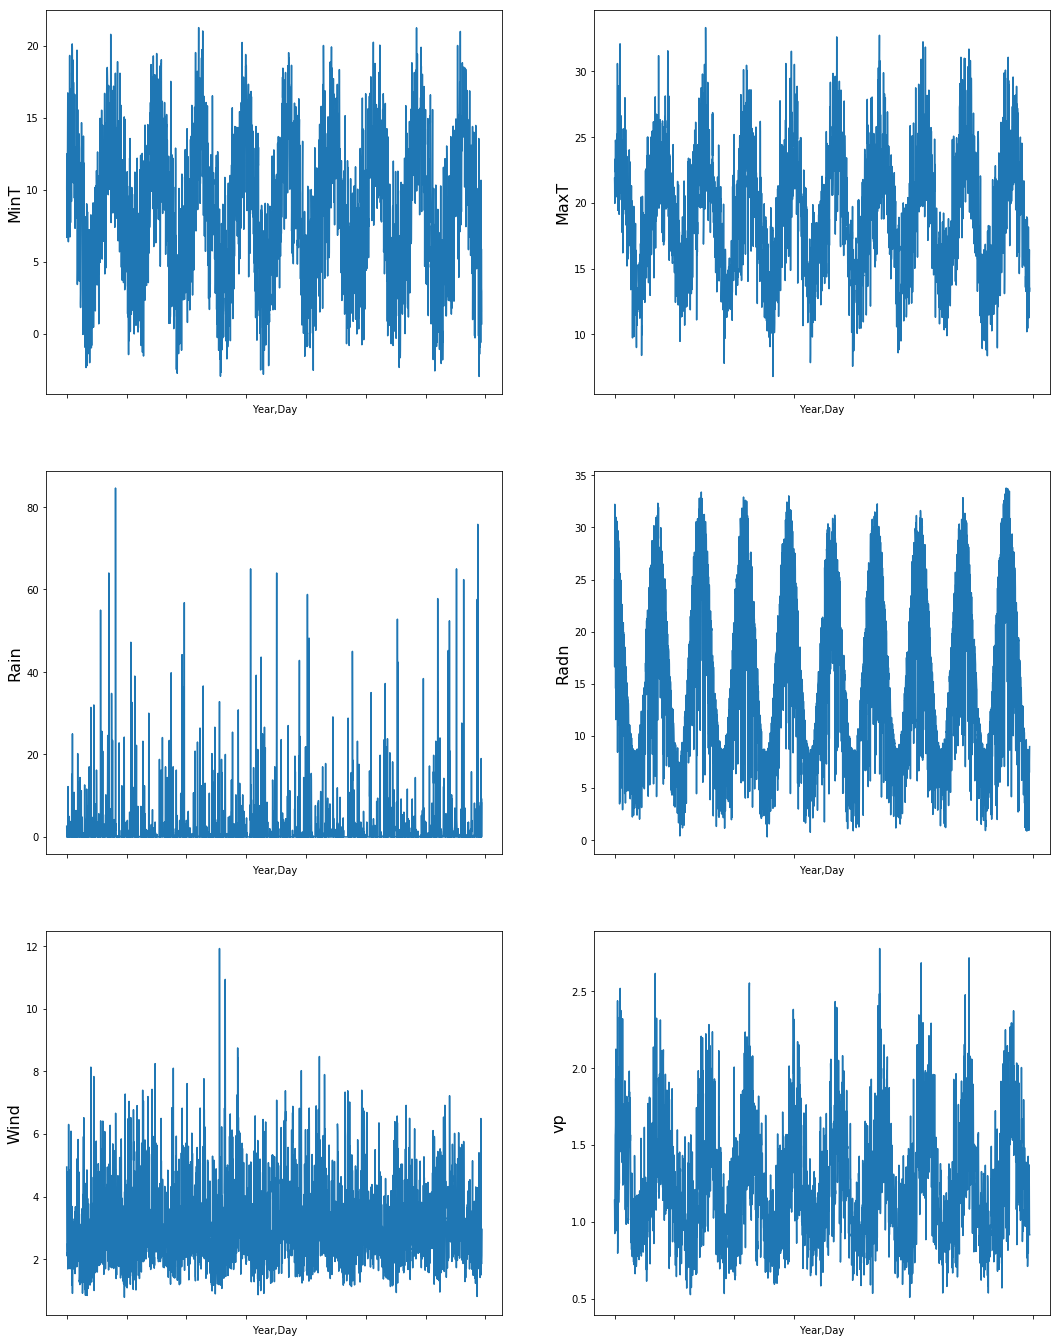

In [10]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp']:
    Fig.add_subplot(3,2,Position)
    CleanData.loc[:,x].plot()
    plt.ylabel(x,fontsize = 16)
    Position +=1

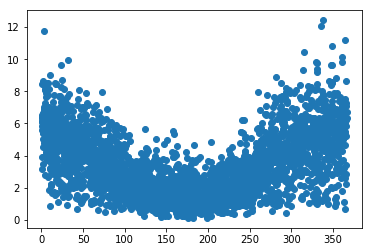

In [11]:
DayIndexed = Data.copy()
DayIndexed.index = DayIndexed.index.droplevel('Year')
plt.plot(DayIndexed.index,DayIndexed.loc[:,'PET'],'o')


In [12]:
Means.PET.to_pickle('MeanPET.pkl')